In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import our custom functions
from src.generators import (
    homogeneous_poisson,
    homogeneous_poisson_with_refractoriness,
    homogeneous_poisson_batch,
    refractory_poisson_batch,
    interspike_intervals
)

from src.analysis import (
    coefficient_of_variation,
    fano_factor,
    fano_factor_across_timescales,
    isi_histogram,
    firing_rate_estimate
)

# Set style for nicer plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All imports successful!")

✓ All imports successful!


print("\n" + "="*70)
print("PART 2: REFRACTORY PERIOD - BIOLOGICAL REALISM")
print("="*70)

print("""
What is a refractory period?
---------------------------
After a neuron fires an action potential, the ion channels need time to reset.
During this time, the neuron CANNOT fire again, no matter how strong the input.

This is called the ABSOLUTE REFRACTORY PERIOD.

Typical duration: 2-5 milliseconds

Why it matters:
- Prevents extremely rapid firing
- Makes spike timing more regular (less random)
- Changes the distribution of interspike intervals
- Creates structure in spike trains

In this notebook, we'll:
1. Generate Poisson spikes with a refractory period constraint
2. Compare to pure Poisson (no constraints)
3. See how statistics change
4. Visualize the differences
""")


In [2]:
# Parameters
firing_rate = 100          # Hz (target rate)
duration = 10              # seconds
refractory_period = 0.002  # 2 milliseconds (2ms)
random_seed = 42

print("\n" + "="*70)
print("GENERATING SPIKE TRAINS")
print("="*70)

# Generate pure Poisson (no constraints)
spikes_poisson = homogeneous_poisson(firing_rate, duration, random_seed=random_seed)

# Generate with refractory period
spikes_refractory = homogeneous_poisson_with_refractoriness(
    firing_rate=firing_rate,
    duration=duration,
    refractory_period=refractory_period,
    random_seed=random_seed
)

# Print comparison
print(f"\nParameters:")
print(f"  Target firing rate: {firing_rate} Hz")
print(f"  Duration: {duration} seconds")
print(f"  Refractory period: {refractory_period*1000:.1f} ms")
print(f"  Expected Poisson spike count: {firing_rate * duration}")

print(f"\nResults:")
print(f"  Poisson spikes: {len(spikes_poisson)} spikes")
print(f"  Realized Poisson rate: {len(spikes_poisson)/duration:.1f} Hz")
print(f"  ")
print(f"  Refractory spikes: {len(spikes_refractory)} spikes")
print(f"  Realized refractory rate: {len(spikes_refractory)/duration:.1f} Hz")
print(f"  ")
print(f"  Difference: {len(spikes_poisson) - len(spikes_refractory)} spikes rejected")
print(f"  ({100*(len(spikes_poisson) - len(spikes_refractory))/len(spikes_poisson):.1f}% of Poisson spikes removed)")




GENERATING SPIKE TRAINS

Parameters:
  Target firing rate: 100 Hz
  Duration: 10 seconds
  Refractory period: 2.0 ms
  Expected Poisson spike count: 1000

Results:
  Poisson spikes: 974 spikes
  Realized Poisson rate: 97.4 Hz
  
  Refractory spikes: 821 spikes
  Realized refractory rate: 82.1 Hz
  
  Difference: 153 spikes rejected
  (15.7% of Poisson spikes removed)


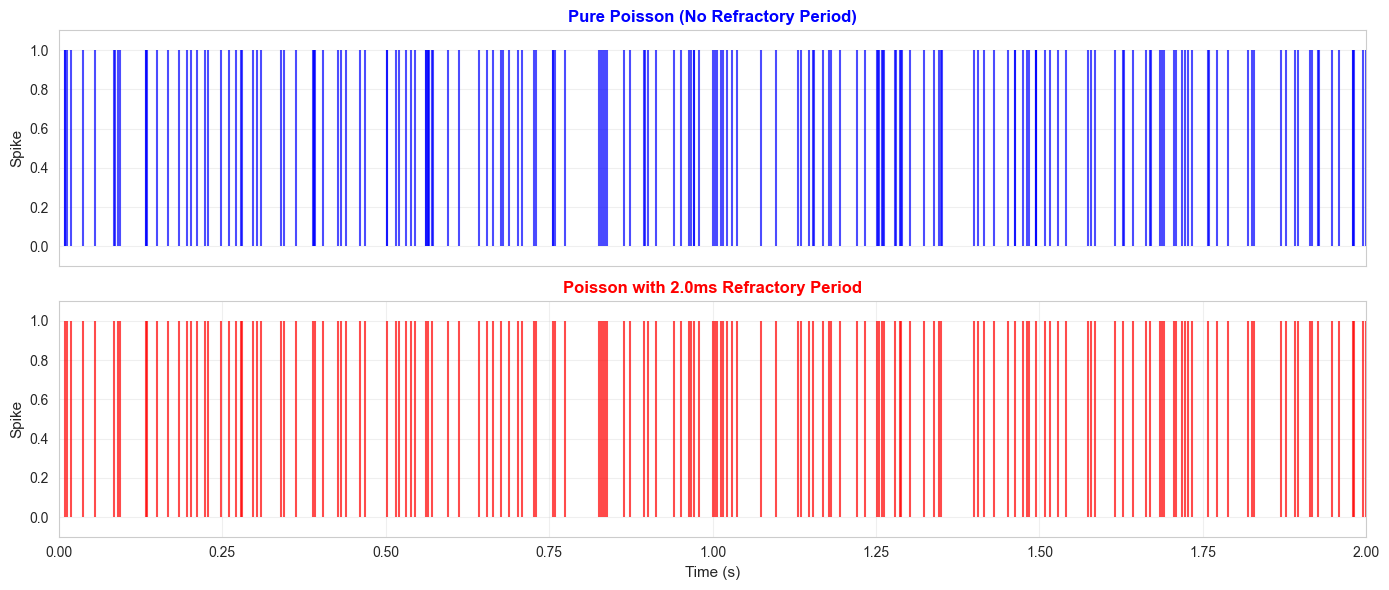


✓ Spike train raster plots complete!

Observation: Notice the refractory spikes are more spread out!


In [3]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Poisson raster
ax = axes[0]
ax.vlines(spikes_poisson, 0, 1, colors='blue', linewidth=1.5, alpha=0.7)
ax.set_xlim(0, 2)  # Zoom to first 2 seconds for clarity
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Spike', fontsize=11)
ax.set_title('Pure Poisson (No Refractory Period)', fontsize=12, fontweight='bold', color='blue')
ax.set_xticks([])
ax.grid(True, alpha=0.3)

# Refractory raster
ax = axes[1]
ax.vlines(spikes_refractory, 0, 1, colors='red', linewidth=1.5, alpha=0.7)
ax.set_xlim(0, 2)  # Same zoom
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Spike', fontsize=11)
ax.set_title(f'Poisson with {refractory_period*1000:.1f}ms Refractory Period', 
             fontsize=12, fontweight='bold', color='red')
ax.set_xlabel('Time (s)', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/05_poisson_vs_refractory_raster.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Spike train raster plots complete!")
print("\nObservation: Notice the refractory spikes are more spread out!")


In [4]:
isis_poisson = interspike_intervals(spikes_poisson)
isis_refractory = interspike_intervals(spikes_refractory)

print(f"\nInterspike Interval Comparison:")
print(f"\nPoisson ISIs:")
print(f"  Mean: {np.mean(isis_poisson)*1000:.3f} ms")
print(f"  Min: {np.min(isis_poisson)*1000:.3f} ms")
print(f"  Count: {len(isis_poisson)}")

print(f"\nRefractory ISIs:")
print(f"  Mean: {np.mean(isis_refractory)*1000:.3f} ms")
print(f"  Min: {np.min(isis_refractory)*1000:.3f} ms (should be ~{refractory_period*1000:.1f} ms)")
print(f"  Count: {len(isis_refractory)}")

print(f"\nKey observation:")
print(f"  Refractory min ISI: {np.min(isis_refractory)*1000:.3f} ms")
print(f"  Refractory period: {refractory_period*1000:.3f} ms")
if np.min(isis_refractory) >= refractory_period * 0.99:
    print(f"  ✓ PASS: All refractory ISIs respect the dead time!")
else:
    print(f"  ✗ FAIL: Some ISIs violate refractory period!")



Interspike Interval Comparison:

Poisson ISIs:
  Mean: 10.248 ms
  Min: 0.003 ms
  Count: 973

Refractory ISIs:
  Mean: 12.160 ms
  Min: 2.009 ms (should be ~2.0 ms)
  Count: 820

Key observation:
  Refractory min ISI: 2.009 ms
  Refractory period: 2.000 ms
  ✓ PASS: All refractory ISIs respect the dead time!


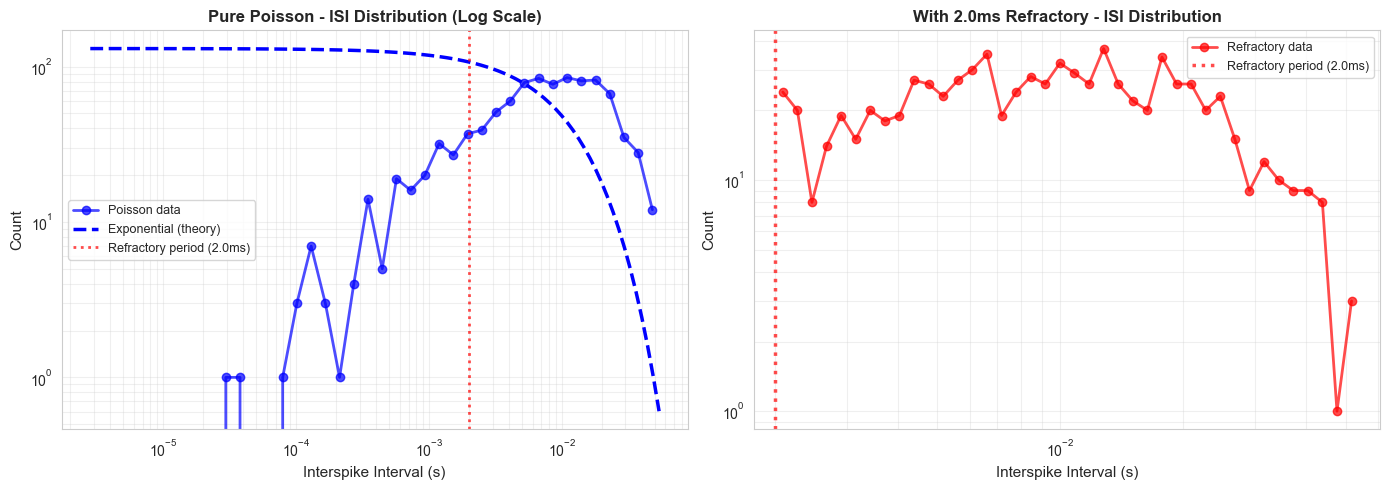


✓ ISI histogram comparison complete!

Key observation:
  - Poisson: All ISIs from ~1ms upward (exponential)
  - Refractory: NO short ISIs! Starts at ~2ms (the refractory period)
  - This 'hole' at short times is characteristic of refractory periods


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Poisson ISI histogram
ax = axes[0]
hist_p, edges_p = isi_histogram(spikes_poisson, n_bins=40, log_scale=True)
bin_centers_p = (edges_p[:-1] + edges_p[1:]) / 2
ax.loglog(bin_centers_p, hist_p, 'o-', linewidth=2, markersize=6, 
          color='blue', label='Poisson data', alpha=0.7)
x_theory = np.logspace(np.log10(np.min(isis_poisson[isis_poisson>0])), 
                        np.log10(np.max(isis_poisson)), 100)
y_theory = len(isis_poisson) * 100 * np.exp(-100 * x_theory) * np.mean(np.diff(edges_p))
ax.loglog(x_theory, y_theory, 'b--', linewidth=2.5, label='Exponential (theory)')
ax.axvline(refractory_period, color='red', linestyle=':', linewidth=2, 
           label=f'Refractory period ({refractory_period*1000:.1f}ms)', alpha=0.7)
ax.set_xlabel('Interspike Interval (s)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Pure Poisson - ISI Distribution (Log Scale)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which='both')

# Refractory ISI histogram
ax = axes[1]
hist_r, edges_r = isi_histogram(spikes_refractory, n_bins=40, log_scale=True)
bin_centers_r = (edges_r[:-1] + edges_r[1:]) / 2
ax.loglog(bin_centers_r, hist_r, 'o-', linewidth=2, markersize=6, 
          color='red', label='Refractory data', alpha=0.7)
ax.axvline(refractory_period, color='red', linestyle=':', linewidth=2.5, 
           label=f'Refractory period ({refractory_period*1000:.1f}ms)', alpha=0.7)
ax.set_xlabel('Interspike Interval (s)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title(f'With {refractory_period*1000:.1f}ms Refractory - ISI Distribution', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../figures/06_isi_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ ISI histogram comparison complete!")
print("\nKey observation:")
print("  - Poisson: All ISIs from ~1ms upward (exponential)")
print("  - Refractory: NO short ISIs! Starts at ~2ms (the refractory period)")
print("  - This 'hole' at short times is characteristic of refractory periods")



In [6]:

cv_poisson = coefficient_of_variation(spikes_poisson)
cv_refractory = coefficient_of_variation(spikes_refractory)

print("\n" + "="*70)
print("COEFFICIENT OF VARIATION COMPARISON")
print("="*70)

print(f"\nSingle Trial:")
print(f"  Poisson CV: {cv_poisson:.4f} (expected: 1.000)")
print(f"  Refractory CV: {cv_refractory:.4f} (expected: < 1.000)")
print(f"  ")
print(f"  Difference: {cv_poisson - cv_refractory:.4f}")
print(f"  Refractory is {(1 - cv_refractory/cv_poisson)*100:.1f}% MORE regular than Poisson")

print(f"\nInterpretation:")
if cv_refractory < cv_poisson:
    print(f"  ✓ Refractory spikes are more regular (lower CV)")
    print(f"    This is expected because refractoriness suppresses short gaps")
else:
    print(f"  ✗ Unexpected: Refractory CV is not lower!")

# Now across many trials
n_trials = 100
print(f"\nGenerating {n_trials} trials for distribution...")

poisson_trials = homogeneous_poisson_batch(firing_rate, duration, n_trials, random_seed=42)
refractory_trials = refractory_poisson_batch(
    firing_rate, duration, refractory_period, n_trials, random_seed=42
)

cv_poisson_trials = []
cv_refractory_trials = []

for p_trial, r_trial in zip(poisson_trials, refractory_trials):
    cv_p = coefficient_of_variation(p_trial)
    cv_r = coefficient_of_variation(r_trial)
    if not np.isnan(cv_p):
        cv_poisson_trials.append(cv_p)
    if not np.isnan(cv_r):
        cv_refractory_trials.append(cv_r)

cv_poisson_trials = np.array(cv_poisson_trials)
cv_refractory_trials = np.array(cv_refractory_trials)

print(f"\n{n_trials} Trials Statistics:")
print(f"\nPoisson CV:")
print(f"  Mean: {np.mean(cv_poisson_trials):.4f}")
print(f"  Std: {np.std(cv_poisson_trials):.4f}")

print(f"\nRefractory CV:")
print(f"  Mean: {np.mean(cv_refractory_trials):.4f}")
print(f"  Std: {np.std(cv_refractory_trials):.4f}")



COEFFICIENT OF VARIATION COMPARISON

Single Trial:
  Poisson CV: 0.9533 (expected: 1.000)
  Refractory CV: 0.7940 (expected: < 1.000)
  
  Difference: 0.1593
  Refractory is 16.7% MORE regular than Poisson

Interpretation:
  ✓ Refractory spikes are more regular (lower CV)
    This is expected because refractoriness suppresses short gaps

Generating 100 trials for distribution...

100 Trials Statistics:

Poisson CV:
  Mean: 0.9984
  Std: 0.0301

Refractory CV:
  Mean: 0.8333
  Std: 0.0289


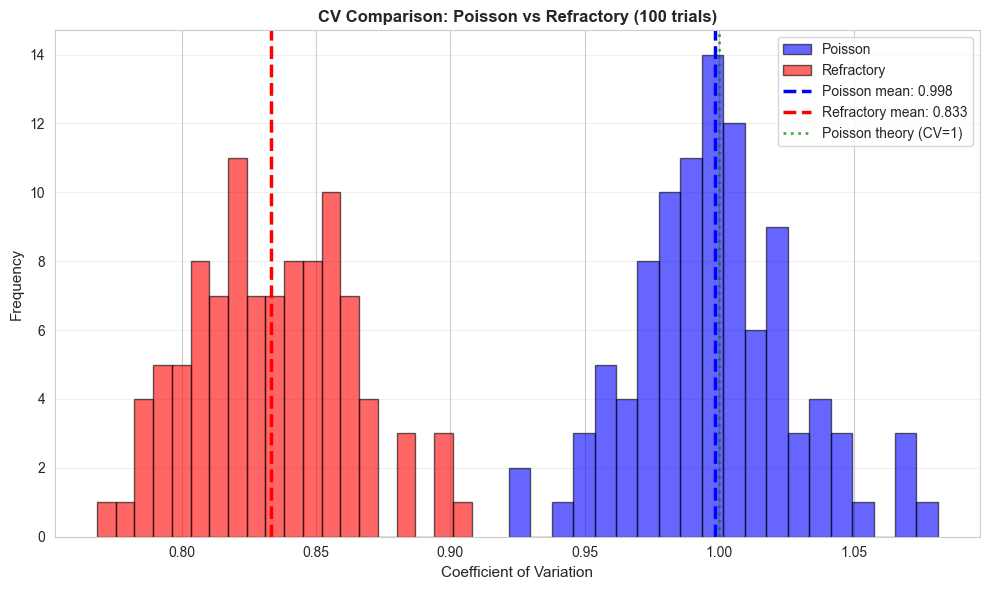


✓ CV comparison plot complete!


In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms
ax.hist(cv_poisson_trials, bins=20, alpha=0.6, color='blue', label='Poisson', edgecolor='black')
ax.hist(cv_refractory_trials, bins=20, alpha=0.6, color='red', label='Refractory', edgecolor='black')

# Add vertical lines for means
ax.axvline(np.mean(cv_poisson_trials), color='blue', linestyle='--', linewidth=2.5,
           label=f'Poisson mean: {np.mean(cv_poisson_trials):.3f}')
ax.axvline(np.mean(cv_refractory_trials), color='red', linestyle='--', linewidth=2.5,
           label=f'Refractory mean: {np.mean(cv_refractory_trials):.3f}')

# Theory lines
ax.axvline(1.0, color='green', linestyle=':', linewidth=2, alpha=0.7,
           label='Poisson theory (CV=1)')

ax.set_xlabel('Coefficient of Variation', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'CV Comparison: Poisson vs Refractory ({n_trials} trials)', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/07_cv_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ CV comparison plot complete!")


In [8]:
print(f"\n" + "="*70)
print("FANO FACTOR COMPARISON")
print("="*70)
print(f"\nCalculating Fano Factor across timescales...")

# Window sizes to test
window_sizes = np.array([0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])

# Calculate for all trials
fano_poisson_all = []
fano_refractory_all = []

for p_trial, r_trial in zip(poisson_trials, refractory_trials):
    fano_p_trial = []
    fano_r_trial = []
    for ws in window_sizes:
        ff_p = fano_factor(p_trial, duration, ws)
        ff_r = fano_factor(r_trial, duration, ws)
        if not np.isnan(ff_p):
            fano_p_trial.append(ff_p)
        else:
            fano_p_trial.append(1.0)
        if not np.isnan(ff_r):
            fano_r_trial.append(ff_r)
        else:
            fano_r_trial.append(1.0)
    fano_poisson_all.append(fano_p_trial)
    fano_refractory_all.append(fano_r_trial)

fano_poisson_all = np.array(fano_poisson_all)
fano_refractory_all = np.array(fano_refractory_all)

mean_ff_poisson = np.mean(fano_poisson_all, axis=0)
std_ff_poisson = np.std(fano_poisson_all, axis=0)
mean_ff_refractory = np.mean(fano_refractory_all, axis=0)
std_ff_refractory = np.std(fano_refractory_all, axis=0)

print(f"\nFano Factor vs Window Size:")
print(f"\n{'Window (s)':<12} {'Poisson FF':<15} {'Refractory FF':<15}")
print("-" * 42)
for ws, ff_p, ff_r in zip(window_sizes, mean_ff_poisson, mean_ff_refractory):
    print(f"{ws:<12.4f} {ff_p:<15.3f} {ff_r:<15.3f}")



FANO FACTOR COMPARISON

Calculating Fano Factor across timescales...

Fano Factor vs Window Size:

Window (s)   Poisson FF      Refractory FF  
------------------------------------------
0.0050       0.996           0.746          
0.0100       0.991           0.720          
0.0200       0.988           0.705          
0.0500       0.988           0.696          
0.1000       0.977           0.685          
0.2000       0.968           0.678          
0.5000       0.941           0.644          
1.0000       0.870           0.602          


In [9]:
print("\n" + "="*70)
print("SUMMARY: POISSON vs REFRACTORY")
print("="*70)

summary_data = {
    'Metric': [
        'Spike Count',
        'Firing Rate (Hz)',
        'Mean CV',
        'Min ISI (ms)',
        'FF @ 10ms window'
    ],
    'Poisson': [
        f"{len(spikes_poisson)}",
        f"{len(spikes_poisson)/duration:.1f}",
        f"{np.mean(cv_poisson_trials):.3f}",
        f"{np.min(isis_poisson)*1000:.3f}",
        f"{mean_ff_poisson[1]:.3f}"
    ],
    'Refractory': [
        f"{len(spikes_refractory)}",
        f"{len(spikes_refractory)/duration:.1f}",
        f"{np.mean(cv_refractory_trials):.3f}",
        f"{np.min(isis_refractory)*1000:.3f}",
        f"{mean_ff_refractory[1]:.3f}"
    ],
    'Interpretation': [
        'Refractoriness removes spikes',
        'Lower rate due to dead time',
        'Refractoriness is more regular',
        'No short intervals due to dead time',
        'More regular at short timescales'
    ]
}

print(f"\n{'Metric':<25} {'Poisson':<15} {'Refractory':<15} {'Interpretation':<35}")
print("-" * 90)
for i in range(len(summary_data['Metric'])):
    m = summary_data['Metric'][i]
    p = summary_data['Poisson'][i]
    r = summary_data['Refractory'][i]
    interp = summary_data['Interpretation'][i]
    print(f"{m:<25} {p:<15} {r:<15} {interp:<35}")


SUMMARY: POISSON vs REFRACTORY

Metric                    Poisson         Refractory      Interpretation                     
------------------------------------------------------------------------------------------
Spike Count               974             821             Refractoriness removes spikes      
Firing Rate (Hz)          97.4            82.1            Lower rate due to dead time        
Mean CV                   0.998           0.833           Refractoriness is more regular     
Min ISI (ms)              0.003           2.009           No short intervals due to dead time
FF @ 10ms window          0.991           0.720           More regular at short timescales   
